# Libraries

In [ ]:
# Import libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.transform import resize
from scipy.linalg import sqrtm
import psutil

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import mixed_precision 
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import (
    Dense, Activation, Reshape, BatchNormalization, Conv2DTranspose, LeakyReLU, Flatten,
    Conv2D, Dropout, Input
)

from tensorflow.keras.models import (
    Sequential, Model
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input


# Env Configuration

In [ ]:
# Showing available GPU
gpus =  tf.config.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Konfigurasi GPU
if gpus:
    try:
        # Set the first available GPU as the only visible device to TensorFlow
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU")  # Confirm that the GPU is being used
    except RuntimeError as e:
        # Handle any errors that occur during the configuration
        print(e)

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Using GPU


# Data Collecting

In [ ]:
# Download latest version
# path = kagglehub.dataset_download("soumikrakshit/anime-faces")

# print("Path to dataset files:", path)

In [ ]:
dataDir = '/kaggle/input/anime-faces/data/data'
label = 'Faces'

# Find images in directory
allFiles = []
for dirname, _, filenames in os.walk(dataDir):
    for filename in filenames:
        allFiles.append(os.path.join(dirname, filename))

# Create Dataframe
imgDF = pd.DataFrame({'filepaths': allFiles, 'label': label})

# Shuffle the Dataframe
imgDF = imgDF.sample(frac=1).reset_index(drop=True)

imgDF

,filepaths,label
0,/kaggle/input/anime-faces/data/data/15246.png,Faces
1,/kaggle/input/anime-faces/data/data/11586.png,Faces
2,/kaggle/input/anime-faces/data/data/12525.png,Faces
3,/kaggle/input/anime-faces/data/data/13047.png,Faces
4,/kaggle/input/anime-faces/data/data/6085.png,Faces
...,...,...
21546,/kaggle/input/anime-faces/data/data/9446.png,Faces
21547,/kaggle/input/anime-faces/data/data/15488.png,Faces
21548,/kaggle/input/anime-faces/data/data/9635.png,Faces
21549,/kaggle/input/anime-faces/data/data/12896.png,Faces


# EDA

In [ ]:
# function to display images
def showImages(img):
  imgFiles = glob.glob(f'{dataDir}/*')
  fig, ax = plt.subplots(ncols=10, figsize=(30, 3))
  for i in range(10):
    img = plt.imread(imgFiles[i])
    ax[i].imshow(img)


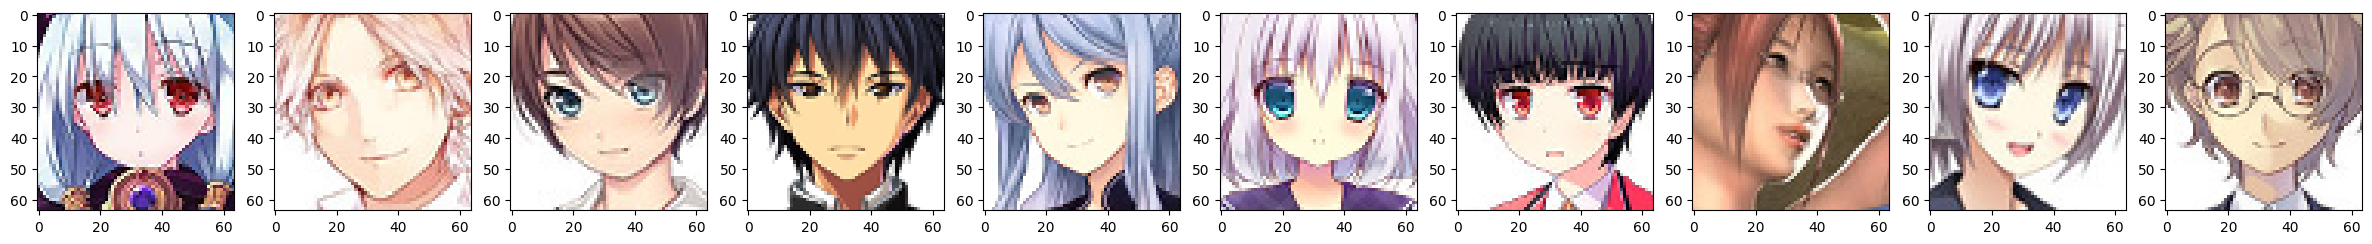

In [ ]:
# show image
showImages(dataDir)

# Model Training

## Image Preprocessing

In [ ]:
trainData = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,  # Directory containing all images
    label_mode=None,  # No labels, since it's for GAN training
    color_mode='rgb',
    batch_size=128,
    image_size=(128, 128),  # Resize all images to 128x128
    shuffle=True  # Shuffle the dataset
).map(lambda x: (x / 127.5) - 1)  # Normalize images to [-1, 1]

trainData = trainData.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 43102 files.


## Support Function

### Checkpoint Function

In [ ]:
def latestCheckpoint(checkPointPath):
    checkpoints = glob.glob(os.path.join(checkPointPath, "generator_checkpoint_chunk_*.weights.h5"))

    if not checkpoints:
        return None

    checkpoints.sort(key=os.path.getmtime)

    return checkpoints[-1]


In [ ]:
def getNextFileNumber(directory, prefix, extension):
    if not os.path.exists(directory):
        os.makedirs(directory)

    files = [f for f in os.listdir(directory) if f.startswith(prefix) and f.endswith(extension)]
    if not files:
        return 0

    if extension == '.png':
        maxNum = max([int(f.split('_')[2]) for f in files])
    else:
        maxNum = max([int(f.replace(prefix, '').replace(extension, '')) for f in files])

    return maxNum


### Model Function

In [ ]:
# Function to build the generator
def buildGenerator(inputDim):
    init = RandomNormal(mean=0.0, stddev=0.02)  # Define kernel initializer

    model = Sequential()  # Initialize a sequential model

    # Dense Layer to expand input dimension
    model.add(Input(shape=(inputDim,)))  # Input layer
    model.add(Dense(8*8*512, kernel_initializer=init))  # Dense layer
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(BatchNormalization())  # Normalize activations
    model.add(Reshape((8, 8, 512)))  # Reshape to prepare for Conv2DTranspose layers

    # First Conv2DTranspose Layer to upscale the image
    model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(BatchNormalization())  # Normalize activations

    # Second Conv2DTranspose Layer
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(BatchNormalization())  # Normalize activations

    # Third Conv2DTranspose Layer
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(BatchNormalization())  # Normalize activations

    # Final Conv2DTranspose Layer to generate the output image
    model.add(Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=init))
    model.add(Activation('tanh'))  # Use tanh activation to scale output values to [-1, 1]

    return model

# Function to build the discriminator
def buildDiscriminator(pixel):
    init = RandomNormal(mean=0.0, stddev=0.02)  # Define kernel initializer

    model = Sequential()  # Initialize a sequential model
    model.add(Input(shape=(pixel, pixel, 3)))  # Input layer for the image

    # First Conv2D Layer
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(Dropout(0.2))  # Dropout to prevent overfitting

    # Second Conv2D Layer
    model.add(Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(Dropout(0.2))  # Dropout to prevent overfitting

    # Third Conv2D Layer
    model.add(Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(Dropout(0.2))  # Dropout to prevent overfitting

    # Fourth Conv2D Layer
    model.add(Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=init))
    model.add(LeakyReLU(negative_slope=0.2))  # Activation function
    model.add(Dropout(0.2))  # Dropout to prevent overfitting

    # Final Conv2D Layer and Flattening
    model.add(Conv2D(1, (4, 4), strides=(1, 1), padding='valid', use_bias=False, kernel_initializer=init))
    model.add(Flatten())  # Flatten the output
    model.add(Activation('sigmoid'))  # Sigmoid activation to get a probability

    return model


The architecture is based on the paper from 2016 publised by Alec Radford & Luke Metz from Indico Research and Soumith Chintala from Facebook AI Research titled 'UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS.' According to them, stable Deep Convolutional GANs should have:
- Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
- Use batchnorm in both the generator and the discriminator.
- Remove fully connected hidden layers for deeper architectures.
- Use ReLU activation in the generator for all layers except for the output, which uses Tanh.
- Use LeakyReLU activation in the discriminator for all layers.

### FID Score

In [ ]:
# Load MobileNetV2 model dengan ukuran input 64x64
model = MobileNetV2(include_top=False, pooling='avg', input_shape=(128, 128, 3))

# Fungsi untuk menghitung FID score
def calculateFid(model, realImages, generatedImages):
    # Preprocess
    realImages = preprocess_input(realImages)
    generatedImages = preprocess_input(generatedImages)

    # Hitung fitur
    realFeatures = model.predict(realImages)
    generatedFeatures = model.predict(generatedImages)

    # Hitung mean dan covariance
    muReal, sigmaReal = realFeatures.mean(axis=0), np.cov(realFeatures, rowvar=False)
    muGen, sigmaGen = generatedFeatures.mean(axis=0), np.cov(generatedFeatures, rowvar=False)

    # Hitung FID score
    ssDiff = np.sum((muReal - muGen)**2.0)
    covMean = sqrtm(sigmaReal.dot(sigmaGen))
    if np.iscomplexobj(covMean):
        covMean = covMean.real
    fid = ssDiff + np.trace(sigmaReal + sigmaGen - 2.0 * covMean)

    return fid

### Image Save Function

In [ ]:
# Function to generate and save images
def generateAndSaveImg(generator, epoch, noiseDim=100, n=2, saveDir='generated_anime_faces'):
    noise = np.random.normal(0, 1, (n, noiseDim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    if not os.path.exists(saveDir):
        os.makedirs(saveDir)

    # Determine next image file number
    nextNum = getNextFileNumber(saveDir, 'generator_epoch_', '.png')

    # Save File
    for i in range(n):
        plt.imsave(os.path.join(saveDir, f'generator_epoch_{nextNum + epoch}_image_{i+1}.png'), generated_images[i])


### Training Function

In [ ]:
def trainGan(gan, generator, discriminator, trainData, epochs, batchSize, inputDim):
    halfBatch = batchSize // 2
    history = {'dLoss': [], 'gLoss': []}

    for epoch in range(epochs):
        epochDLoss = []
        epochGLoss = []

        for realImages in trainData:
            # Resize and normalize real images
            realImages = tf.image.resize(realImages, [64, 64], method=tf.image.ResizeMethod.BICUBIC)
            realImages = (realImages - 0.5) * 2

            # Generate fake images
            noise = tf.random.normal((halfBatch, inputDim))
            fakeImages = generator(noise, training=True)

            # Label smoothing and noise injection
            realLabels = tf.random.uniform((halfBatch, 1), 0.9, 1.0)
            fakeLabels = tf.zeros((halfBatch, 1))

            # Train Discriminator
            discriminator.trainable = True
            dLossReal = discriminator.train_on_batch(realImages[:halfBatch], realLabels)
            dLossFake = discriminator.train_on_batch(fakeImages, fakeLabels)
            dLoss = 0.5 * np.add(dLossReal, dLossFake)
            epochDLoss.append(dLoss)

            # Train Generator
            discriminator.trainable = False
            noise = tf.random.normal((batchSize, inputDim))
            gLoss = gan.train_on_batch(noise, tf.ones((batchSize, 1)))
            epochGLoss.append(gLoss)

        # Average loss per epoch
        avgDLoss = np.mean(epochDLoss)
        avgGLoss = np.mean(epochGLoss)
        history['dLoss'].append(avgDLoss)
        history['gLoss'].append(avgGLoss)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} | D loss: {avgDLoss:.4f}, G loss: {avgGLoss:.4f}")

    return history


In [ ]:
# Function to train model in chunks
def trainModelChunks(gan, generator, discriminator, data, totalEpochs,
                     chunkSize=100, batchSize=16, inputDim=100):
    totalChunks = totalEpochs // chunkSize
    realImagesBatch = next(iter(data.take(1)))
    realImagesBatch = 0.5 * (realImagesBatch + 1)
    overallHistory = {'dLoss': [], 'gLoss': []}

    # Determine next chunk file number
    nextChunkNum = getNextFileNumber('.', 'generator_checkpoint_chunk_', '.weights.h5')

    for chunk in range(totalChunks):
        # Checking RAM usage
        mem = psutil.virtual_memory()
        ramThreshold = 0.6
        if mem.percent >= ramThreshold * 100:
            print("RAM usage is high! Stopping training to avoid out of memory error.")
            break

        try:
            print(f"Training chunk {chunk + 1}/{totalChunks}")

            history = trainGan(gan, generator, discriminator, data, epochs=chunkSize, batchSize=batchSize, inputDim=inputDim)

            # Save the model
            nextChunkNum += 1
            generator.save_weights(f'generator_checkpoint_chunk_{nextChunkNum}.weights.h5')
            discriminator.save_weights(f'discriminator_checkpoint_chunk_{nextChunkNum}.weights.h5')

            # Generate and save images after each chunk
            generateAndSaveImg(generator, chunkSize)

            # Append chunk history to overall history
            overallHistory['dLoss'].extend(history['dLoss'])
            overallHistory['gLoss'].extend(history['gLoss'])

            realImagesBatch = next(iter(trainData.take(1)))
            realImagesBatch = 0.5 * (realImagesBatch + 1)
            noiseForFid = np.random.normal(0, 1, (realImagesBatch.shape[0], 100))
            generatedImagesForFid = generator.predict(noiseForFid)
            fidScore = calculateFid(model, realImagesBatch, generatedImagesForFid)
            print(f"FID Score : {fidScore}")
        except RuntimeError as e:
            print("Failed to train", e)
            break

        # clear ram
        tf.keras.backend.clear_session()

    return overallHistory


## Build Model and Configuration

In [ ]:
# Build model
inputDim = 100
pixel = 64
generator = buildGenerator(inputDim)
discriminator = buildDiscriminator(pixel)

# Generator Summary
generator.summary()

# Discriminator Summary
discriminator.summary()

# Load Latest Checkpoint
lastModelCheckPoint = latestCheckpoint(Path().cwd())
# lastModelCheckPoint = latestCheckpoint('/kaggle/input/dcgan/tensorflow1/default/1')

if lastModelCheckPoint is not None:
    print(f"Continue from latest checkpoint: {lastModelCheckPoint}")

    # Load only weights
    generator.load_weights(lastModelCheckPoint)
    discriminator.load_weights(lastModelCheckPoint.replace('generator', 'discriminator'))
else:
    print("No Checkpoint found, start model from beginning")

# Initialize the Adam optimizer
generatorOptimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminatorOptimizer = Adam(learning_rate=0.0001, beta_1=0.3)

# Compile discriminator independently
discriminator.compile(loss='binary_crossentropy', optimizer=discriminatorOptimizer, metrics=['accuracy'])

# Freeze discriminator when creating GAN
discriminator.trainable = False

# Create the GAN model
gan_input = Input(shape=(inputDim,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

# Compile GAN model
gan.compile(loss='binary_crossentropy', optimizer=generatorOptimizer)

gan.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         1,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,139,328 (23.42 MB)

 Trainable params: 6,072,896 (23.17 MB)

 Non-trainable params: 66,432 (259.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       131,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 1)        │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,763,776 (10.54 MB)

 Trainable params: 2,763,776 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

Continue from latest checkpoint: /kaggle/working/generator_checkpoint_chunk_48.weights.h5


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 64, 64, 3)      │     6,139,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │     2,763,776 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,903,104 (33.96 MB)

 Trainable params: 6,072,896 (23.17 MB)

 Non-trainable params: 2,830,208 (10.80 MB)

## Training Model

In [ ]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Train Data
targetEpochs = 50
chunkSize = 1
currentEpochs = getNextFileNumber('generated_anime_faces', 'generator_epoch_', '.png')
epochs = targetEpochs - currentEpochs

with tf.device('/GPU:0'):
    history = trainModelChunks(gan, generator, discriminator, trainData,
                               totalEpochs=epochs, chunkSize=chunkSize, batchSize=128)


Training chunk 1/2


I0000 00:00:1732460892.273512  199951 service.cc:145] XLA service 0x7ef8ec004480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732460892.273552  199951 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732460900.426476  199951 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-24 15:08:39.840114: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[128,32,32,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[128,65,65,64]{3,2,1,0}, f16[128,3,3,64]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-24 15:08:4

Epoch 1/1 | D loss: 0.3436, G loss: 0.4301
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 920ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
FID Score : 5124.631783393884
Training chunk 2/2
Epoch 1/1 | D loss: 0.3451, G loss: 0.4306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
FID Score : 5163.129584751689


Given the limitations of available RAM and the frequent crashes caused by the model's high RAM requirements, it is essential to use checkpoints and train in batches. This approach ensures that if a crash occurs, the training process can resume from the last saved checkpoint, preventing the loss of progress. We are using a total of 50 epochs, and training is conducted one epoch at a time.

## Model Evaluation

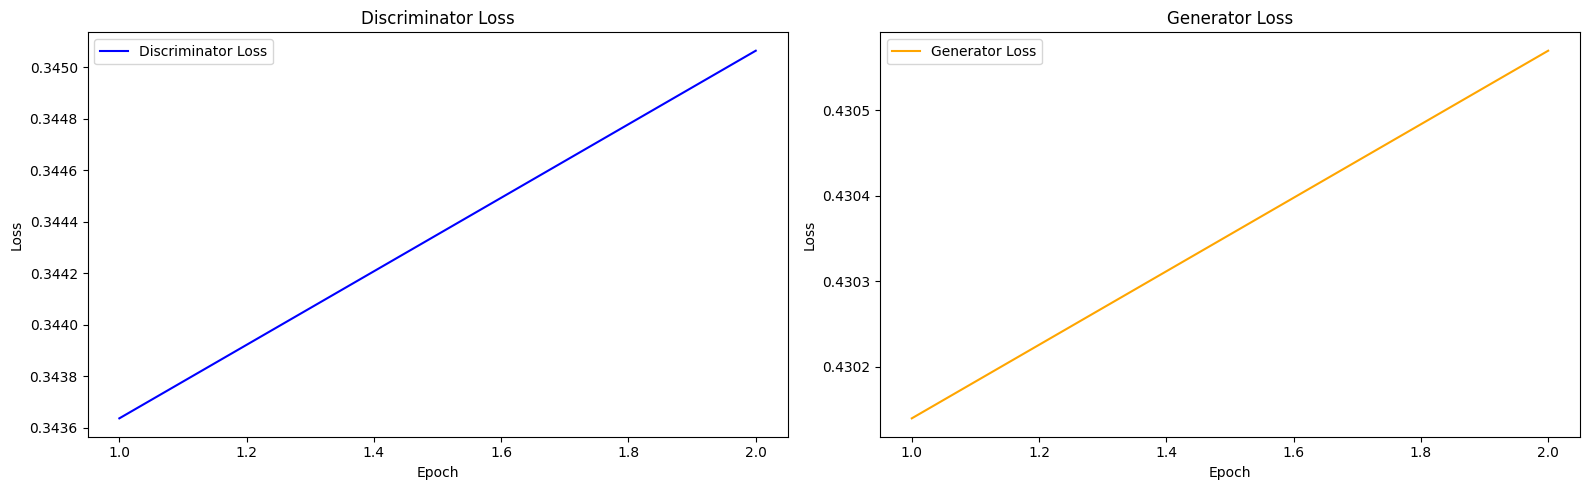

In [ ]:
# Plot Model Loss
fig, ax = plt.subplots(ncols=2, figsize=(16, 5))

# Plot Discriminator Loss
ax[0].plot(range(1, len(history['dLoss']) + 1), history['dLoss'], label='Discriminator Loss', color='blue')
ax[0].set_title('Discriminator Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot Generator Loss
ax[1].plot(range(1, len(history['gLoss']) + 1), history['gLoss'], label='Generator Loss', color='orange')
ax[1].set_title('Generator Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Show plot
plt.tight_layout()
plt.show()


### Image Evaluation

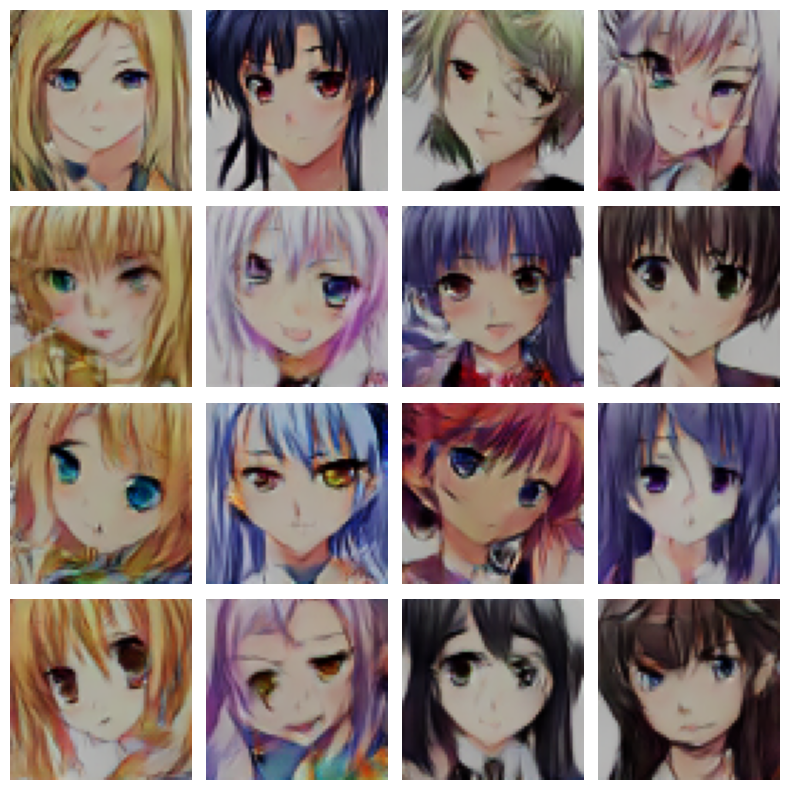

In [ ]:
# Function to generate and display images
def generateAndDisplayImages(generator, noiseDim=100, numImages=16):
    # Generate noise
    noise = np.random.normal(0, 1, (numImages, noiseDim))

    # Generate images
    genImgs = generator(noise, training=False)

    # Convert Tensor to NumPy array
    genImgs = genImgs.numpy()

    # Rescale images to [0, 1]
    genImgs = 0.5 * genImgs + 0.5

    # Convert to uint8 for compatibility with matplotlib
    genImgs = (genImgs * 255).astype(np.uint8)

    # Plot the generated images
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    count = 0
    for i in range(4):
        for j in range(4):
            # Handle grayscale or RGB
            if genImgs.shape[-1] == 1:  # Grayscale
                axs[i, j].imshow(genImgs[count, :, :, 0], cmap='gray')
            else:  # RGB
                axs[i, j].imshow(genImgs[count])
            axs[i, j].axis('off')
            count += 1
    plt.tight_layout()
    plt.show()

# Display generated images
generateAndDisplayImages(generator, noiseDim=100, numImages=32)


In [ ]:
# Calculate FID score
realImagesBatch = next(iter(trainData.take(1)))
realImagesBatch = 0.5 * (realImagesBatch + 1)
noiseForFid = np.random.normal(0, 1, (realImagesBatch.shape[0], 100))
generatedImagesForFid = generator.predict(noiseForFid)
fidScore = calculateFid(model, realImagesBatch, generatedImagesForFid)
print(fidScore)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  
5176.918532676071


From the evaluation results, the GAN-generated images closely resemble the images in the dataset used. However, the colors in the images appear slightly faded. This fading could be due to several reasons, such as the model's tendency to average pixel values, which may affect the model's ability to capture vibrant colors accurately. The FID (Fréchet Inception Distance) score remained stable at 5000 from the beginning to the end of the training process, indicating consistent performance throughout the training period.